In [1]:
from PIL import Image
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import clip
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os
import math
import warnings
import re # regular expressions to remove special characters and digits
import matplotlib.image as mpimg
import textwrap

In [2]:
# Configuration
class Config:
    def __init__(self):
        self.image_path = Path('../Original/')
        self.data_csv = '../Tabdata/dataset_train_refined.csv'
        self.model_path = '../models/clip_refined_84k.pth'  # Provide the path to your trained model

device = "cuda" if torch.cuda.is_available() else "cpu"
# Configuration
config = Config()

In [3]:
# Load the saved model state_dict
model_state_dict = torch.load(config.model_path)

# Create an instance of the CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)  # Use the same architecture you used during training

In [4]:
# Load the saved model state_dict into the model
model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [5]:
embed_clip = pd.read_pickle('../Tabdata/embed_img_text_84k.pkl.gz')

In [6]:
embed_clip.head()

,image_embeddings,labels,text_embeddings
0,"[[0.1208399, -0.07618336, -0.09887697, -0.6747...",heart shaped box,"[-0.32495117, -0.07751465, -0.08929443, -0.420..."
1,"[[0.043106988, 0.11443147, -0.018512733, -0.26...",outsole for a shoe,"[-0.019515991, -0.35302734, 0.16772461, -0.313..."
2,"[[0.0943451, -0.12552038, 0.026479954, -0.0437...",portion of a shoe upper,"[-0.36401367, -0.17626953, -0.01626587, -0.133..."
3,"[[0.18645407, 0.19901562, -0.053182304, 0.1816...",laptop case,"[0.06890869, -0.08239746, -0.39453125, -0.0252..."
4,"[[0.24037173, -0.0043958314, -0.3750218, -0.20...",handbag,"[0.12573242, -0.2548828, -0.24841309, 0.249877..."


In [7]:
# Read the dataset
df = pd.read_csv(config.data_csv)
image_file_names = [config.image_path / i for i in df['figure_file']]
labels = df['refined_object_title'].values.tolist()
ids = df['id'].values.tolist()

In [8]:
df.head(5)

,Unnamed: 0,id,patentID,patentdate,figid,caption,object,aspect,figure_file,object_title,refined_object_title
0,0,1,USD0557896-20071225,2007-12-25,8,FIG. 8 is a perspective view from the front an...,Heart-shaped box,perspective view from the front and side,USD0557896-20071225-D00004.png,Heart-shaped box,heart shaped box
1,1,2,USD0557885-20071225,2007-12-25,3,FIG. 3 is a left side view thereof;,Outsole for a shoe,left side view,USD0557885-20071225-D00003.png,Outsole for a shoe,outsole for a shoe
2,2,3,USD0557891-20071225,2007-12-25,1,FIG. 1 is a front perspective view of a portio...,Portion of a shoe upper,front perspective view,USD0557891-20071225-D00001.png,Portion of a shoe upper,portion of a shoe upper
3,3,4,USD0557897-20071225,2007-12-25,2,FIG. 2 is a front view thereof.,Laptop case,front view,USD0557897-20071225-D00002.png,Laptop case,laptop case
4,4,5,USD0557895-20071225,2007-12-25,7,FIG. 7 is a bottom view of the handbag shown i...,Handbag,bottom view,USD0557895-20071225-D00007.png,Handbag,handbag


In [9]:
# function to generate text embeddings
def generate_text_embeddings(labels, batch_size=32):
    # Tokenize all labels
    tok_text = clip.tokenize(labels).to(device)

    # Calculate the total number of batches
    num_batches = (len(labels) + batch_size - 1) // batch_size
    
    # Initialize an empty tensor to store the final text features
    text_features = torch.empty((len(labels), model.text_projection.shape[-1])).to(device)

    with torch.no_grad():
        # Process data in batches
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(labels))

            # Extract a batch of tokenized text
            batch_tok_text = tok_text[start_idx:end_idx]

            # Encode text features for the batch
            batch_text_features = model.encode_text(batch_tok_text)

            # Store the batch text features in the final tensor
            text_features[start_idx:end_idx] = batch_text_features
    
    return text_features



In [10]:
# generate text embedding
prompt_embedding = generate_text_embeddings(['sports duffle bag']).cpu().numpy()

In [11]:
# Convert the 'image_embeddings' column to a numpy array
img_embeddings_array = np.vstack(embed_clip['image_embeddings'].to_numpy())

In [12]:
# Calculate cosine similarity between the new embedding and all embeddings in the DataFrame
def vsearch(prompt_embedding, img_embeddings_array=img_embeddings_array):
    similarity_scores = cosine_similarity(prompt_embedding.reshape(1, -1), img_embeddings_array)
    
    # Create a new column in the DataFrame with the similarity scores
    df['cosine_similarity'] = similarity_scores[0]
    
    # Sort the DataFrame by the cosine similarity column in descending order
    df_sorted = df.sort_values(by='cosine_similarity', ascending=False)

    return df_sorted

In [13]:
%time
df_sorted = vsearch(prompt_embedding)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.77 µs


In [14]:
df_sorted.head(10)

,Unnamed: 0,id,patentID,patentdate,figid,caption,object,aspect,figure_file,object_title,refined_object_title,cosine_similarity
44804,55343,55344,USD0544204-20070612,2007-06-12,12,FIG. 12 is a left side elevational view thereo...,Handbag,left side elevational view,USD0544204-20070612-D00012.png,Handbag,handbag,0.339853
82661,102361,102362,USD0544204-20070612,2007-06-12,11,FIG. 11 is a right side elevational view thereof;,Handbag,right side elevational view,USD0544204-20070612-D00011.png,Handbag,handbag,0.331894
7144,8826,8827,USD0546059-20070710,2007-07-10,1,FIG. 1 is a perspective view showing my new ha...,Handbag,perspective view,USD0546059-20070710-D00001.png,Handbag,handbag,0.329193
77860,96393,96394,USD0550452-20070911,2007-09-11,5,FIG. 5 is a right side view of the purse.,Sport purse,right side view,USD0550452-20070911-D00005.png,Sport purse,sport purse,0.324443
1091,1385,1386,USD0550803-20070911,2007-09-11,1,FIG. 1 is a front perspective view of a childr...,Children's play tent,front perspective view,USD0550803-20070911-D00001.png,Children's play tent,child s play tent,0.323634
48967,60479,60480,USD0550951-20070918,2007-09-18,3,FIG. 3 is a left side perspective view thereof...,Cane catcher,left side perspective view,USD0550951-20070918-D00002.png,Cane catcher,cane catcher,0.322973
70438,87181,87182,USD0554853-20071113,2007-11-13,4,"FIG. 4 is a bottom plan view thereof; and,",Combined backpack and solar panel,bottom plan view,USD0554853-20071113-D00004.png,Combined backpack and solar panel,combined backpack and solar panel,0.321053
46784,57749,57750,USD0557160-20071211,2007-12-11,2,"FIG. 2 is a perspective view thereof, shown in...",Bracelet,perspective view,USD0557160-20071211-D00002.png,Bracelet,bracelet,0.320080
55342,68323,68324,USD0555008-20071113,2007-11-13,1,"FIG. 1 is a right, front, perspective view of ...","Bag for carrying, displaying, and serving beve...","right , front , perspective view",USD0555008-20071113-D00001.png,"Bag for carrying, displaying, and serving beve...",bag for carrying displaying and serving beverage,0.319024
15431,19081,19082,USD0556390-20071127,2007-11-27,5,FIG. 5 is a front elevation view thereof;,Pet pendant,front elevation view,USD0556390-20071127-D00002.png,Pet pendant,pet pendant,0.318936


In [15]:
# print sample images from dataset
def print_sample_illustrations(df, n=10, patentid=None, image_column='figure_file', caption_column=['refined_object_title']):

    if patentid is not None:
        df = df[df['patentID'] == patentid]
    
    # Handling the case where n is 1
    if n == 1:
        fig, ax = plt.subplots()
        img_path = os.path.join(os.getcwd(), '../Original/', df.iloc[0][image_column])
        img = mpimg.imread(img_path)
        ax.imshow(img, cmap='gray')  # Set a grayscale colormap
            
        # Set title as caption with reduced font size and word wrap
        caption = '\n'.join([f'{caption_column[j]}: {df.iloc[0][caption_column[j]]}' for j in range(len(caption_column))])
        wrapped_caption = textwrap.fill(caption, width=20)  # Adjust width as needed
        ax.set_title(wrapped_caption, fontsize=8)  # Adjust fontsize as needed

        # Remove x and y axis ticks
        ax.set_xticks([])
        ax.set_yticks([])

    else:
        # Adjusting the number of columns based on whether n is even or odd
        if n % 2 == 0:
            fig, axes = plt.subplots(2, int(n / 2))
        else:
            fig, axes = plt.subplots(int(math.floor(n / 2)), int((n + 1) / 2))

        # Iterate only up to the second-to-last element if n is odd
        for i, ax in enumerate(axes.flatten()[:-1] if n % 2 == 1 else axes.flatten()):
            # Load and display image
            img_path = os.path.join(os.getcwd(), '../Original/', df.iloc[i][image_column])
            img = mpimg.imread(img_path)
            ax.imshow(img, cmap='gray')  # Set a grayscale colormap

            # Set title as caption with reduced font size and word wrap
            caption = '\n'.join([f'{caption_column[j]}: {df.iloc[i][caption_column[j]]}' for j in range(len(caption_column))])
            wrapped_caption = textwrap.fill(caption, width=20)  # Adjust width as needed
            ax.set_title(wrapped_caption, fontsize=8)  # Adjust fontsize as needed

            # Remove x and y axis ticks
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()

    plt.show()

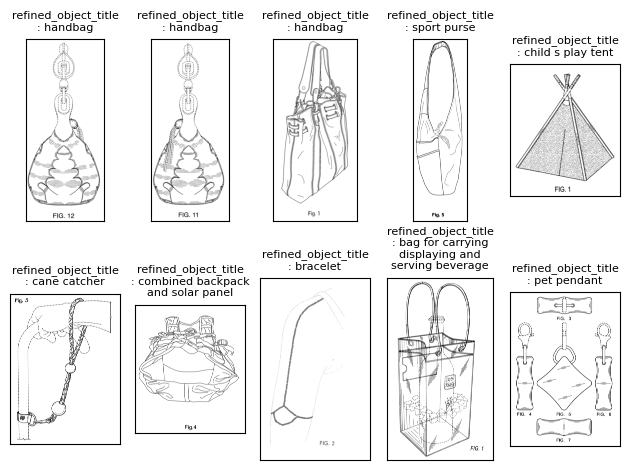

In [16]:
print_sample_illustrations(df_sorted, n = 10)